# Are You Bored Yet? — Detecting Mouse Disengagement

## Importing required libraries

In [84]:
%pip install --quiet ONE-api
%pip install --quiet ibllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from one.api import ONE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [85]:
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


## Data Loading and Subject selection

In [86]:
datasets = one.alyx.rest('datasets', 'list', tag='2021_Q1_IBL_et_al_Behaviour', name='_ibl_subjectTrials.table.pqt')
subjects = np.unique([d['file_records'][0]['relative_path'].split('/')[2] for d in datasets])

# Load in the subjectTrials table and sessionTrials table for the first subject
subject = subjects[0]
subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')

# Add in lab, task_protocol, subject name information from the sessions table
if 'task_protocol' in subject_trials:
    subject_trials = subject_trials.drop('task_protocol', axis=1)
subject_trials = subject_trials.set_index('session').join(session_trials.drop('date', axis=1))

The `subject_trials` table contains all the trials data for each training session collected in the subject. See [here](https://www.google.com/url?q=https%3A%2F%2Fdocs.google.com%2Fdocument%2Fd%2F1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg%2Fedit%23heading%3Dh.ls81qq9ihg4x) for more information about this dataset.

In [87]:
# Find the number of sessions for this subject
n_sessions = subject_trials.index.unique().size
print(f'Subject {subject} has {n_sessions} sessions')

# Find the number of times a task protocol was run
n_protocols = subject_trials[~subject_trials.index.duplicated()].task_protocol.value_counts()
print(n_protocols)

Subject CSHL045 has 76 sessions
task_protocol
_iblrig_tasks_biasedChoiceWorld6.3.1      17
_iblrig_tasks_trainingChoiceWorld6.1.3    14
_iblrig_tasks_trainingChoiceWorld6.2.5    12
_iblrig_tasks_trainingChoiceWorld6.3.1    11
_iblrig_tasks_biasedChoiceWorld6.2.5       6
_iblrig_tasks_trainingChoiceWorld6.0.6     3
_iblrig_tasks_trainingChoiceWorld6.2.4     3
_iblrig_tasks_ephysChoiceWorld6.2.5        3
_iblrig_tasks_trainingChoiceWorld6.2.1     2
_iblrig_tasks_ephysChoiceWorld6.4.0        2
_iblrig_tasks_trainingChoiceWorld6.1.1     1
_iblrig_tasks_trainingChoiceWorld6.1.2     1
_iblrig_tasks_trainingChoiceWorld6.2.0     1
Name: count, dtype: int64


We can get the trials data for an individual session of choice, here a the first session using the `biasedChoiceWorld` protocol

In [88]:
# Get the trials data for a single session
# Find a session run under biasedChoiceWorld
sess = subject_trials[subject_trials['task_protocol'].str.contains('biasedChoiceWorld')].index.unique()[0]
trials = subject_trials[subject_trials.index == sess]

Using this data we can plot the psychometric curve and compute some performance metrics, for example the number of trials in the session or the performance of the mouse on easy trials (50% and 100% contrast)

Number of trials for session a4f7079b-d157-4de9-ba80-de9a98f35c8b: 682
Performance easy for session a4f7079b-d157-4de9-ba80-de9a98f35c8b: 0.9457364341085271


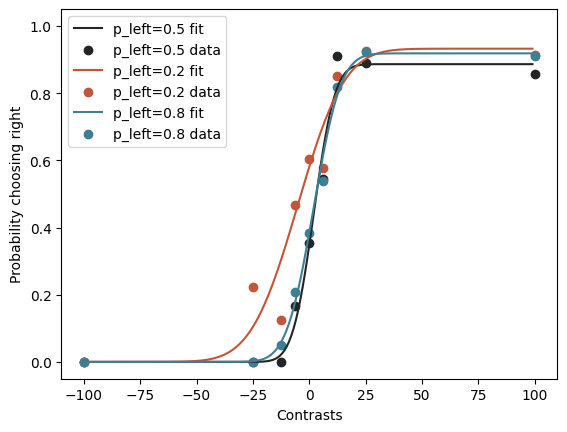

In [89]:
from brainbox.behavior.training import plot_psychometric, compute_n_trials, compute_performance_easy, compute_performance

plot_psychometric(trials)
n_trials = compute_n_trials(trials)
perf_easy = compute_performance_easy(trials)
print(f'Number of trials for session {sess}: {n_trials}')
print(f'Performance easy for session {sess}: {perf_easy}')

In [90]:
subject_trials.head()

,intervals_0,intervals_1,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,...,phase,position,quiescence,protocol_number,session_start_time,lab,subject,number,task_protocol,projects
session,,,,,,,,,,,,,,,,,,,,,
b117ed10-6871-42b3-9193-ca708dac4353,0.0000,89.642702,6.9477,12.0563,1.0,6.9297,1.0,NaN,12.0563,1.0,...,0.000000,-35,0.639317,0,2019-11-04 09:29:50.380830,churchlandlab,CSHL045,1,_iblrig_tasks_trainingChoiceWorld6.0.6,ibl_neuropixel_brainwide_01
b117ed10-6871-42b3-9193-ca708dac4353,90.2706,100.694903,90.8707,99.1949,1.0,90.8403,1.0,NaN,99.1949,1.0,...,0.552481,-35,0.445501,0,2019-11-04 09:29:50.380830,churchlandlab,CSHL045,1,_iblrig_tasks_trainingChoiceWorld6.0.6,ibl_neuropixel_brainwide_01
b117ed10-6871-42b3-9193-ca708dac4353,101.6900,109.067302,102.2129,107.5673,-1.0,102.1760,NaN,0.5,107.5673,1.0,...,0.196815,35,0.413207,0,2019-11-04 09:29:50.380830,churchlandlab,CSHL045,1,_iblrig_tasks_trainingChoiceWorld6.0.6,ibl_neuropixel_brainwide_01
b117ed10-6871-42b3-9193-ca708dac4353,109.5048,121.653802,116.0801,119.1538,1.0,116.0465,NaN,1.0,119.1865,-1.0,...,0.396885,35,0.649984,0,2019-11-04 09:29:50.380830,churchlandlab,CSHL045,1,_iblrig_tasks_trainingChoiceWorld6.0.6,ibl_neuropixel_brainwide_01
b117ed10-6871-42b3-9193-ca708dac4353,122.2313,129.362803,125.2503,127.8628,1.0,125.2174,1.0,NaN,127.8628,1.0,...,2.169886,-35,0.419072,0,2019-11-04 09:29:50.380830,churchlandlab,CSHL045,1,_iblrig_tasks_trainingChoiceWorld6.0.6,ibl_neuropixel_brainwide_01


In [91]:
subject_trials.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59805 entries, b117ed10-6871-42b3-9193-ca708dac4353 to 7939711b-8b4d-4251-b698-b97c1eaa846e
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   intervals_0              59805 non-null  float64       
 1   intervals_1              59805 non-null  float64       
 2   goCue_times              59805 non-null  float64       
 3   response_times           59805 non-null  float64       
 4   choice                   59805 non-null  float64       
 5   stimOn_times             59771 non-null  float64       
 6   contrastLeft             29263 non-null  float64       
 7   contrastRight            30542 non-null  float64       
 8   feedback_times           59801 non-null  float64       
 9   feedbackType             59805 non-null  float64       
 10  rewardVolume             59805 non-null  float64       
 11  probabilityLeft          59805 n

In [92]:
# Filter by task protocol
filtered_trials = subject_trials[subject_trials['task_protocol'].str.contains('biasedChoiceWorld')]
print(f"Number of trials after filtering: {filtered_trials.shape[0]}")

sessions = filtered_trials.index.unique()
print(f"Number of biasedChoiceWorld sessions: {len(sessions)}")


Number of trials after filtering: 22310
Number of biasedChoiceWorld sessions: 23


## Feature engineering 

<b>Features added:</b>

1. <b>Reaction Time</b>

--Captures how fast the subject responded after the cue.

--Useful for: cognitive load, attention, or fatigue modeling

2. <b>Inter Trial Delay</b>

--Time between the start of successive trials.

--Useful for: modeling effects of spacing or breaks

3. <b>Block</b>

--Divides the session into 50-trial blocks.

--Useful for: analyzing trends across blocks (e.g. learning, fatigue).

4. <b>Rolling Performance</b>

--20-trial rolling average of correctness.

--Useful for: tracking short-term performance slumps or boosts.


In [93]:
def extra_features(trials_df):
    """
    Adds engineered features to trials DataFrame:
    - reaction_time: time between go cue and response
    - inter_trial_delay: time between trial starts
    - block: trial blocks (every 50 trials) to get trends
    - rolling_performance: rolling mean of correct responses over 20 trials

    Args:
        trials_df (pd.DataFrame): Trial data with columns 'response_times', 'goCue_times', 'intervals_0', 'feedbackType'

    Returns:
        pd.DataFrame: original DataFrame with added feature columns
    """
    
    df = trials_df.copy()
    
    # 1. Reaction time = response_time - goCue_time
    df['reaction_time'] = df['response_times'] - df['goCue_times']
    
    # 2. Delay between trials (intervals_0 is start time)
    df['trial_start_time'] = df['intervals_0']
    df['inter_trial_delay'] = df['trial_start_time'].diff().fillna(0)
    
    # 3. Block ID: every 50 trials
    df['trial_id'] = np.arange(len(df))
    df['block'] = df['trial_id'] // 50
    
    # 4. Performance drop (rolling accuracy)
    df['correct'] = df['feedbackType'] == 1
    df['rolling_performance'] = df['correct'].rolling(20, min_periods=1).mean()

    return df

<b>Plotting the extra features over time

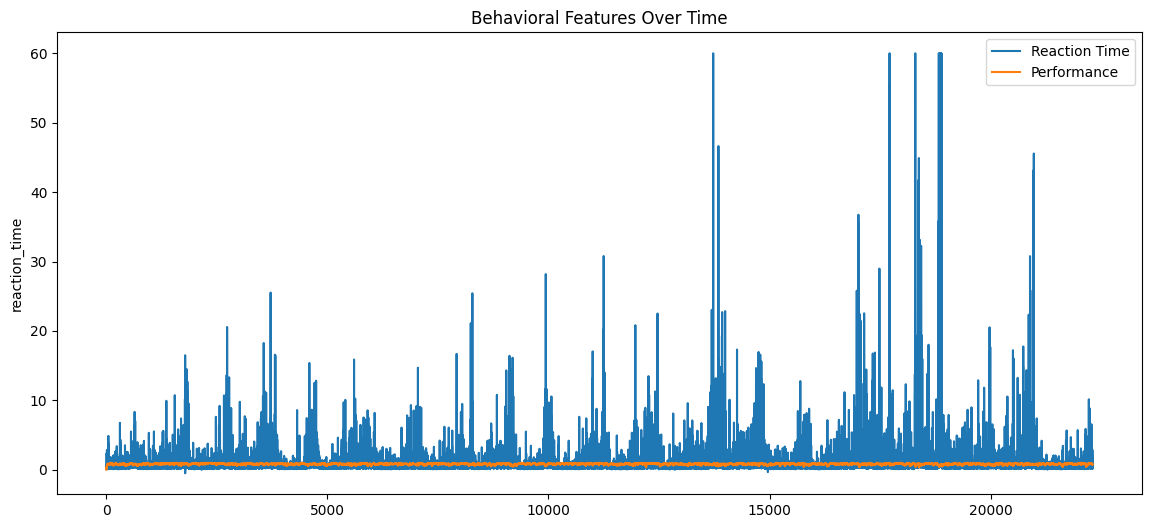

In [94]:
df= extra_features(filtered_trials)
plt.figure(figsize=(14, 6))
sns.lineplot(x=range(len(df)), y=df['reaction_time'], label='Reaction Time')
sns.lineplot(x=range(len(df)), y=df['rolling_performance'], label='Performance')

plt.title("Behavioral Features Over Time")
plt.legend()
plt.show()

### Calculation of Boredom Score
<b>Reaction time (RT):</b> Increased reaction time implies disengagement (Most Indicative: Highest weightage- 40%)

<b>Inter-trial delay:</b> Longer delays suggest hesitation or distraction (30% Weightage)

<b>Rolling performance:</b> Decline in performance is a fatigue or disengagement marker (30% Weightage)


All these features are Z-scaled and then clipped to remove outliers

In [95]:
def compute_boredom_score(df, smooth_window=5):
    """
    Compute a continuous boredom score using normalized reaction time,
    inter-trial delay, and performance drop, with smoothing.

    Args:
        df (pd.DataFrame): must contain 'reaction_time', 'inter_trial_delay', 'rolling_performance'
        smooth_window (int): rolling window size for smoothing boredom score

    Returns:
        pd.DataFrame: input df with 'boredom_score_raw' and 'boredom_score' columns added
    """
    # Fill missing values
    df[['reaction_time', 'inter_trial_delay', 'rolling_performance']] = df[['reaction_time', 'inter_trial_delay', 'rolling_performance']].fillna(method='ffill').fillna(method='bfill')

    # z-score normalization
    def zscore(x):
        return (x - x.median()) / (x.quantile(0.75) - x.quantile(0.25))  
    
    # Clipping within a reasonable range to remove outliers
    rt_z = zscore(df['reaction_time']).clip(-3, 3)
    delay_z = zscore(df['inter_trial_delay']).clip(-3, 3)
    perf_drop = 1 - df['rolling_performance']

    # boredom score 
    boredom_score = 0.4 * rt_z + 0.3 * delay_z + 0.3 * perf_drop
    boredom_score = boredom_score.fillna(0)

    df['boredom_score_raw'] = boredom_score
    df['boredom_score'] = boredom_score.rolling(smooth_window, min_periods=1).mean()
    return df


<b>Plotting boredom score over trials

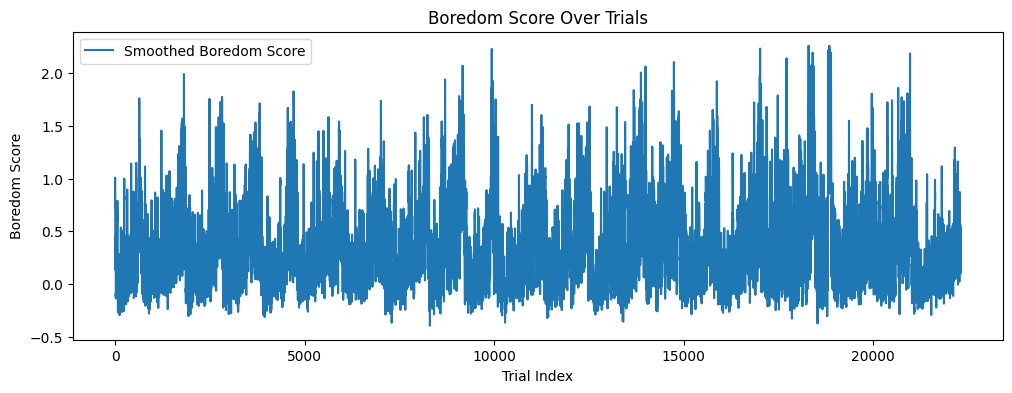

In [96]:
df = extra_features(filtered_trials)
df = compute_boredom_score(df, smooth_window=5)
plt.figure(figsize=(12, 4))
sns.lineplot(x=range(len(df)), y=df['boredom_score'], label='Smoothed Boredom Score')
plt.title("Boredom Score Over Trials")
plt.xlabel("Trial Index")
plt.ylabel("Boredom Score")
plt.legend()
plt.show()

<b>Addition of Temporal Features:<br></b>
 This is adding features from previous trials. This is especially helpful in time-series or behavioral modeling where a participant's current behavior (e.g., reaction time or boredom) is influenced by their recent history.

In [97]:
def add_lag_features(df,n_lags):
    """
    Adds lagged features to the DataFrame for reaction time, rolling performance, and inter-trial delay.
    Args:
        df (pd.DataFrame): DataFrame with columns 'reaction_time', 'rolling_performance', 'inter_trial_delay'
        n_lags (int): number of lags to create
    Returns:
        pd.DataFrame: DataFrame with lagged features added
    """
    
    df = df.copy()
    df['reaction_time_lag'] = df['reaction_time'].shift(n_lags)
    df['rolling_performance_lag'] = df['rolling_performance'].shift(n_lags)
    df['inter_trial_delay_lag'] = df['inter_trial_delay'].shift(n_lags)
    df = df.fillna(method='bfill')  # fill initial NaNs
    return df

## Model Training

In [99]:
train_sessions, test_sessions = train_test_split(sessions, test_size=0.2, random_state=42)

In [100]:
# Collect all sessions as training data
all_data = []
for sess in train_sessions:  
    trials = filtered_trials[filtered_trials.index == sess]
    trials = extra_features(trials)
    trials = compute_boredom_score(trials)
    trials = add_lag_features(trials, n_lags=1)
    all_data.append(trials)

train_df = pd.concat(all_data)
features = ['reaction_time', 'inter_trial_delay', 'rolling_performance','reaction_time_lag', 'rolling_performance_lag', 'inter_trial_delay_lag']
X_train = train_df[features]
y_train = train_df['boredom_score']

<b>Implementing a Random Forest Regressor to predict boredom score

In [101]:
# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

<b>Feature Importance

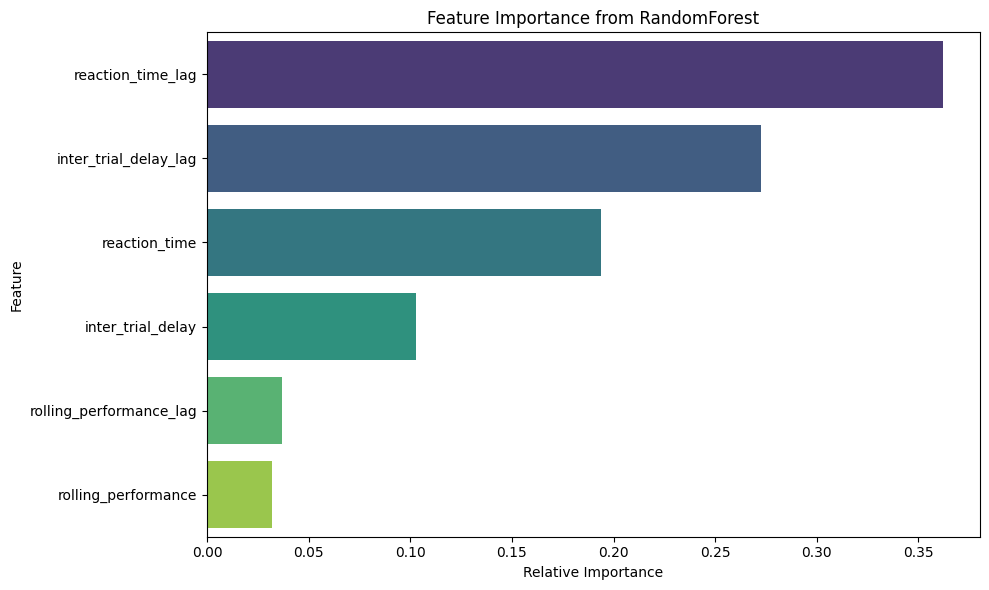

In [110]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from RandomForest')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

<b>This feature importance shows that Reaction Time and its temporal version are the most important features for prediction

In [111]:
feature_importance_df

,Feature,Importance
3,reaction_time_lag,0.362181
5,inter_trial_delay_lag,0.272684
0,reaction_time,0.193647
1,inter_trial_delay,0.102792
4,rolling_performance_lag,0.036923
2,rolling_performance,0.031773


## Evaluation

In [ ]:
results = []
all_errors = []

for i, session in enumerate(test_sessions, 1):
    test_df = filtered_trials[filtered_trials.index == session]
    
    if len(test_df) < 5:
        continue
    
    try:
        #Process test data
        test_df = extra_features(test_df)
        test_df = compute_boredom_score(test_df)
        test_df = add_lag_features(test_df, n_lags=1)
        
        X_test = test_df[features]
        y_test = test_df['boredom_score']
        y_pred = model.predict(X_test)

        test_df['predicted_boredom_score'] = y_pred
        test_df['error'] = test_df['boredom_score'] - test_df['predicted_boredom_score']
        test_df['session'] = session
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, y_pred)

        results.append({
            'session': session,
            'n_trials': len(test_df),
            'mae': mae,
        })
        # Append errors for analysis
        all_errors.append(test_df[['error', 'session']])

    except Exception as e:
        print(f"Skipping session {session} due to error: {e}")
        continue

# Final results
results_df = pd.DataFrame(results)
all_errors_df = pd.concat(all_errors, ignore_index=True)


<b> Mean Absolute Error across test sessions

In [134]:
results_df.sort_values(by='mae')


,session,n_trials,mae
1,81362661-8f80-45b1-90ad-749251c9fe13,865,0.172339
2,a4f7079b-d157-4de9-ba80-de9a98f35c8b,682,0.177259
0,a55aafed-b496-49fb-8948-680695f806d5,1022,0.181604
3,85501aad-64e6-4137-a44e-2c933c9eec5f,931,0.193859
4,b88016fd-146a-4238-ac7c-ab8e3e1264bf,736,0.199539


In [131]:
error_df = pd.concat(all_errors)
error_df = error_df.reset_index(drop=True)

<b>Error distribution plots for each of test sessions

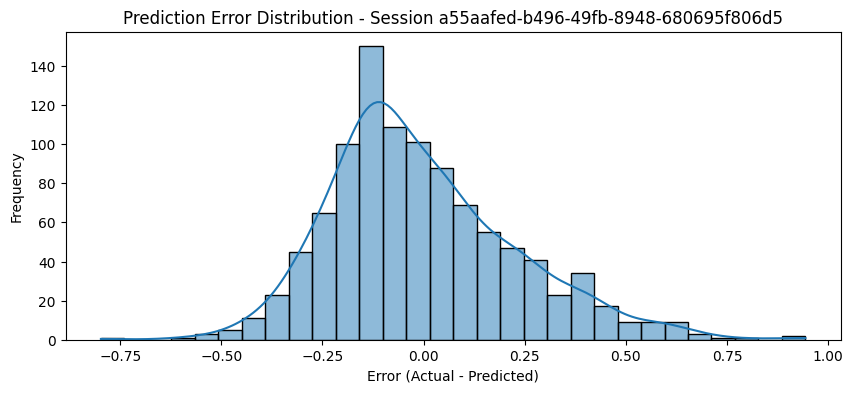

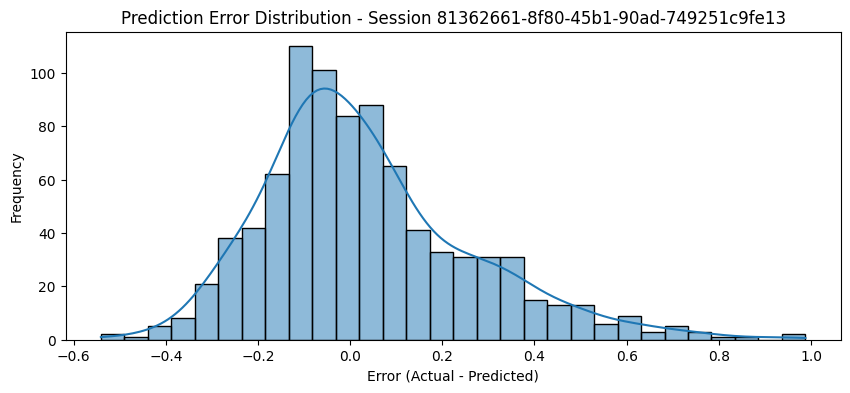

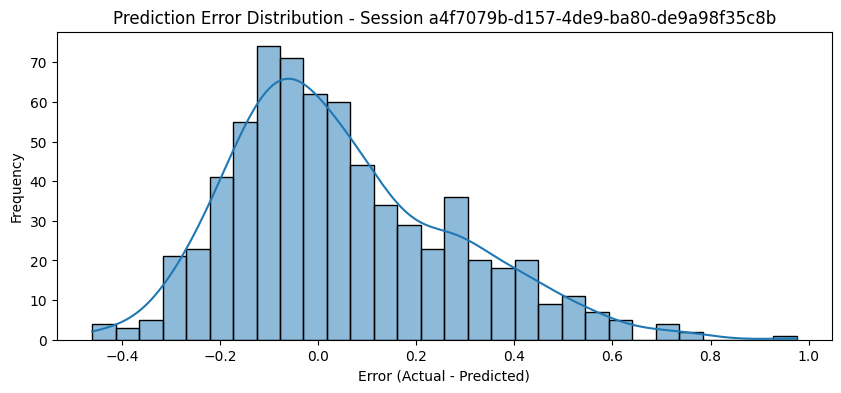

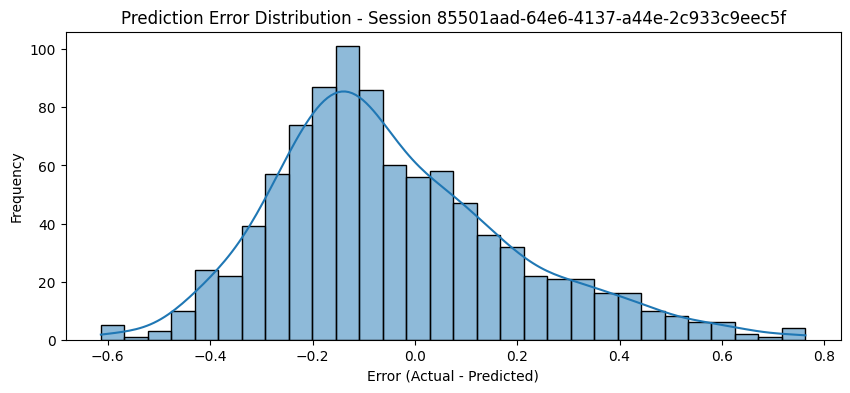

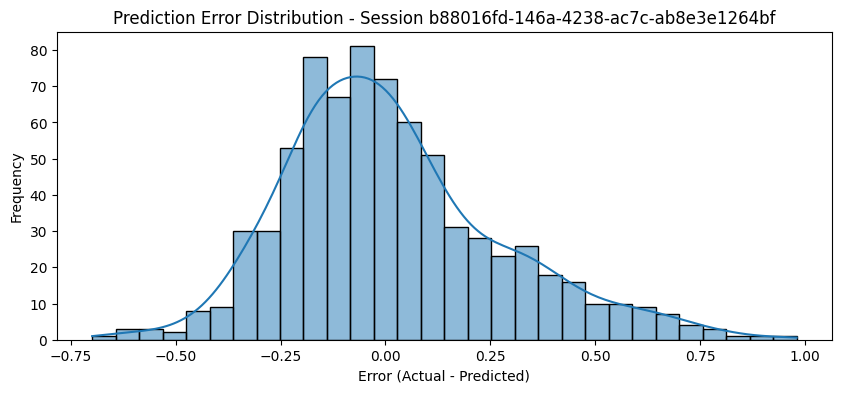

In [136]:
# Plot error distribution for each test session
for error_df in all_errors:
    session_id = error_df['session'].iloc[0]
    plt.figure(figsize=(10, 4))
    sns.histplot(error_df['error'], bins=30, kde=True)
    plt.title(f"Prediction Error Distribution - Session {session_id}")
    plt.xlabel("Error (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.show()

<b>Plot of boredom score prediction with actual for the best MAE out of the test sessions

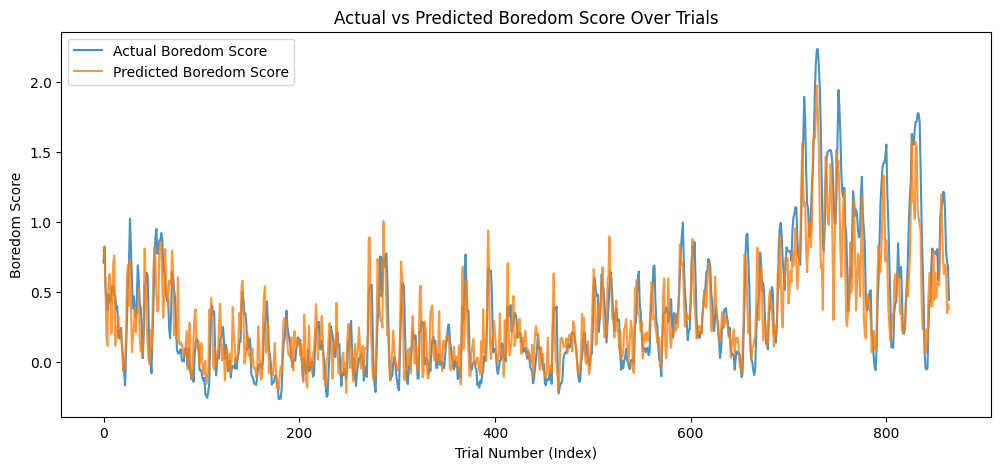

Mean Absolute Error (MAE): 0.172


In [138]:
def plot_boredom_prediction(df_test):
    
    plt.figure(figsize=(12, 5))
    plt.plot(df_test.index, df_test['boredom_score'], label='Actual Boredom Score', alpha=0.8)
    plt.plot(df_test.index, df_test['predicted_boredom_score'], label='Predicted Boredom Score', alpha=0.8)
    plt.xlabel('Trial Number (Index)')
    plt.ylabel('Boredom Score')
    plt.title('Actual vs Predicted Boredom Score Over Trials')
    plt.legend()
    plt.show()

    mae = mean_absolute_error(df_test['boredom_score'], df_test['predicted_boredom_score'])
    print(f'Mean Absolute Error (MAE): {mae:.3f}')

best_session = results_df.sort_values('mae').iloc[0]['session']
test_df = filtered_trials[filtered_trials.index == best_session]
test_df = extra_features(test_df)
test_df = compute_boredom_score(test_df)
test_df = add_lag_features(test_df, n_lags=1)
test_df['predicted_boredom_score'] = model.predict(test_df[features])
df_test = test_df.reset_index(drop=True)
plot_boredom_prediction(df_test)